<a href="https://colab.research.google.com/github/jjone36/Groot/blob/master/96_cnn_Doodle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Catch Doodle!: Quick draw

In [0]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set(style='white', context='notebook')

In [2]:
import ast
import cv2

from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

Using TensorFlow backend.


## Load data

In [3]:
# Connecting to kaggle API
from google.colab import files
file = files.upload()

Saving kaggle.json to kaggle.json


In [0]:
from getpass import getpass
user = 'jjone36'
key = ''

if '.kaggle' not in os.listdir('/root'):
    !mkdir ~/.kaggle
!touch /root/.kaggle/kaggle.json
!chmod 666 /root/.kaggle/kaggle.json
with open('/root/.kaggle/kaggle.json', 'w') as f:
    f.write('{"username":"%s","key":"%s"}' % (user, key))
!chmod 600 /root/.kaggle/kaggle.json

In [5]:
!kaggle competitions download -c quickdraw-doodle-recognition

 95% 5.00M/5.24M [00:00<00:00, 14.0MB/s]
100% 5.24M/5.24M [00:00<00:00, 13.2MB/s]
 99% 585M/589M [00:11<00:00, 43.0MB/s]
100% 589M/589M [00:11<00:00, 53.7MB/s]
 98% 58.0M/59.0M [00:01<00:00, 30.8MB/s]
100% 59.0M/59.0M [00:01<00:00, 43.6MB/s]
100% 65.9G/65.9G [28:57<00:00, 40.3MB/s]
100% 65.9G/65.9G [28:57<00:00, 40.7MB/s]
100% 7.37G/7.37G [02:52<00:00, 48.5MB/s]
100% 7.37G/7.37G [02:52<00:00, 45.9MB/s]


In [0]:
# Unzip the file
from zipfile import ZipFile
zf = ZipFile('train_simplified.zip', 'r')

In [0]:
# list of animals 
animals = ['ant', 'bat', 'bear', 'bee', 'bird', 'butterfly', 'camel', 'cat', 'cow',
           'crab', 'crocodile', 'dog', 'dolphin', 'dragon', 'duck', 'elephant', 'fish',
           'flamingo', 'frog', 'giraffe', 'hedgehog', 'horse', 'kangaroo', 'lion',
           'lobster', 'monkey', 'mosquito', 'mouse', 'octopus', 'owl', 'panda',
           'parrot', 'penguin', 'pig', 'rabbit', 'raccoon', 'rhinoceros', 'scorpion',
           'sea turtle', 'shark', 'sheep', 'snail', 'snake', 'spider', 'squirrel',
           'swan', 'teddy-bear', 'tiger', 'whale', 'zebra']

In [0]:
# Import data: animals only
for a in animals:
  file = a + str('.csv')
  zf.extract(file, path= '/content/animals')

In [9]:
dir_path = '/content/animals/'

am = pd.read_csv(dir_path + animals[0] + '.csv')
am.head()

,countrycode,drawing,key_id,recognized,timestamp,word
0,US,"[[[27, 17, 16, 21, 34, 50, 49, 34, 23, 17], [4...",5421013154136064,True,2017-03-27 00:14:57.310330,ant
1,US,"[[[27, 0, 7, 40, 47, 20], [0, 41, 74, 73, 41, ...",4836123148812288,True,2017-03-06 20:00:22.521560,ant
2,US,"[[[34, 18, 14, 4, 1, 2, 10, 18, 46, 69, 83, 89...",5720952853757952,True,2017-01-23 19:53:28.354530,ant
3,US,"[[[59, 33, 16, 10, 61, 71, 69], [33, 36, 46, 5...",6345979559149568,True,2017-03-14 14:52:27.521410,ant
4,US,"[[[17, 16, 19], [140, 167, 177]], [[81, 82, 87...",4704383923126272,True,2017-01-25 21:48:31.256400,ant


In [0]:
# Take only recognizable drawings
am = am[am.recognized == True]

In [0]:
# Attach other files into one dataframe
for a in animals[1:]:
    df = pd.read_csv(dir_path + a + '.csv')
    df = df[df.recognized == True]
    am = am.append(df)

In [12]:
# Checking
am.word.nunique()

50

## Data Distribution check

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


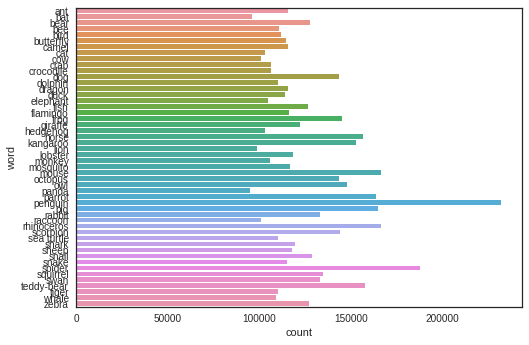

In [13]:
# Distributions of animals
sns.countplot(y = 'word', data = am)

In [0]:
# Resampling 
n = 100000
am_2 = pd.DataFrame(columns= am.columns)

for a in animals:
  df = am[am['word'] == a]
  if len(df) > n:
    df = df.sample(n)
    am_2 = am_2.append(df)
  else:
    am_2 = am_2.append(df)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


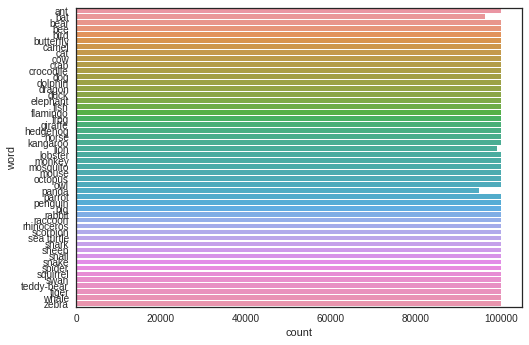

In [15]:
# Checking again
sns.countplot(y = 'word', data = am_2)

In [0]:
# Reindexing
am_2 = am_2.sample(frac = 1).reset_index(drop = True)

## Let's draw doodle!

In [17]:
am_2.head()

,countrycode,drawing,key_id,recognized,timestamp,word
0,US,"[[[69, 48, 0, 27, 58, 60, 54], [163, 201, 255,...",5560213966946304,True,2017-03-03 21:57:35.241590,mosquito
1,US,"[[[27, 0, 15, 27, 35, 45, 61, 70, 59, 58, 83, ...",5441834400612352,True,2017-03-13 17:18:36.502950,shark
2,US,"[[[122, 125, 119, 75, 25, 4, 0, 5, 30, 93, 139...",5841621406973952,True,2017-03-31 20:59:33.545940,rhinoceros
3,US,"[[[165, 152, 143, 145, 161, 198, 221, 245, 255...",4998423017160704,True,2017-03-01 16:17:54.336950,dog
4,FR,"[[[81, 78, 82, 86, 96, 110, 122, 122, 117, 106...",5480291172876288,True,2017-01-18 17:26:12.625450,monkey


In [0]:
ex = am_2.sample(100)

In [0]:
ex['drawing'] = ex.drawing.apply(ast.literal_eval)

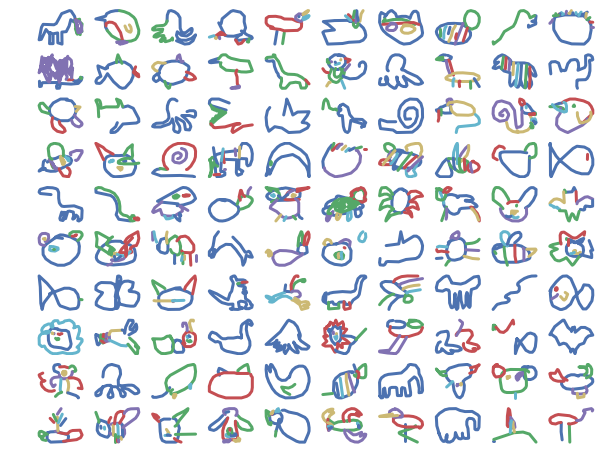

In [20]:
fig, axs = plt.subplots(nrows = 10, ncols = 10, figsize = (10, 8))

for index, col in enumerate(ex.drawing):
    ax = axs[index//10, index%10]
    for x, y in col:
        ax.plot(x,-np.array(y), lw = 3)
    ax.axis('off')
    
plt.show()

## Data preprocessing

In [0]:
y = am_2.word
X = am_2.drawing

In [0]:
# Encodding
y = pd.get_dummies(y)

In [0]:
im_size = 128
n_class = len(animals)

In [0]:
# define a function converting drawing to image data
def draw_to_img(strokes, im_size):
    strokes = ast.literal_eval(strokes)
    fig, ax = plt.subplots()
    for x, y in strokes:
        ax.plot(x, -np.array(y), lw = 10)
    ax.axis('off')
    fig.canvas.draw()
    A = np.array(fig.canvas.renderer._renderer)
    plt.close('all')
    plt.clf()
    # image resizing. Original X is of various size due to strokes variable's length
    A = (cv2.resize(A, (im_size, im_size)) / 255.)
    
    return A

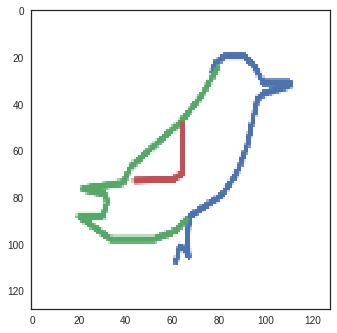

In [46]:
image = draw_to_img(X[50], im_size)
plt.imshow(image)

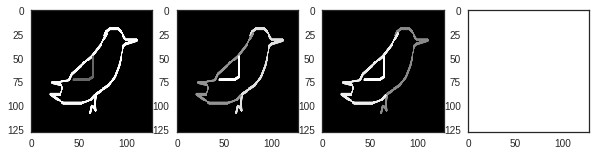

In [47]:
# Channel selection 
fig, axs = plt.subplots(nrows = 1, ncols = 4, figsize = (10, 10))

for i in range(4):
    ax = axs[i]
    ax.imshow(image[:, :, i])

In [0]:
# redefine
def draw_to_img(strokes):
    strokes = ast.literal_eval(strokes)
    fig, ax = plt.subplots()
    for x, y in strokes:
        ax.plot(x, -np.array(y), lw = 10)
    ax.axis('off')
    fig.canvas.draw()
    A = np.array(fig.canvas.renderer._renderer)
    plt.close('all')
    plt.clf()
    # image resizing. Original X is of various size due to strokes variable's length
    A = (cv2.resize(A, (im_size, im_size)) / 255.)
    
    return A[:, :, 0]

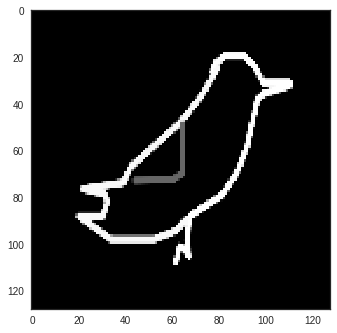

In [58]:
image = draw_to_img(X[50])
plt.imshow(image)

In [50]:
image.shape

(128, 128)

In [0]:
# Split the validation set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = .3, random_state = 36)

In [0]:
# Converting all drawing strokes into image data


In [0]:
# Applying to all
X = am_2.drawing.apply(draw_to_img)

## Modeling

In [0]:
n_epochs = 10
batch_size = 512

In [0]:
# Initialize
model = Sequential()

# ConvNet_1
model.add(Conv2D(128, kernel_size = 3, input_shape = (im_size, im_size, 1), padding = 'same', activation = 'relu'))
model.add(MaxPool2D(2, strides = 2))

# ConvNet_2
model.add(Conv2D(64, kernel_size = 3, activation = 'relu'))
model.add(MaxPool2D(2, strides = 2))

# Flattening
model.add(Flatten())

# Fully connected
model.add(Dense(512, activation = 'relu'))

# Dropout
model.add(Dropout(.5))

# Final layer
model.add(Dense(n_class), activation = 'softmax')

# Compile
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [0]:
model.summary()

In [0]:
# Callback
stopper = EarlyStopping(patience = 3)

reducer = ReduceLROnPlateau(monitor = 'val_acc',
                           patience = 3,
                           verbose = 1,
                           factor = .5,
                           min_lr = 0.00001)

callbacks = [stopper, reducer]

In [0]:
history = model.fit(X_train, y_train, epochs = n_epoch, batch_size = batch_size, validation_split = .2, verbose = True)

## Plot the result

In [0]:
history.history['loss']

In [0]:
# Train and validation curves
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(history.history['loss'], color = 'b', label = 'Train Loss')
ax1.plot(history.history['val_loss'], color = 'm', label = 'Validation Loss')
ax1.legend(loc = 'best')

ax2.plot(history.history['acc'], color = 'b', label = 'Train Accuracy')
ax2.plot(history.history['val_acc'], color = 'm', label = 'Validation Loss')
ax2.legend(loc = 'best')